<a href="https://colab.research.google.com/github/samsung-chow/324-Project/blob/main/MLP_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload cleaned_data.CSV (in github repo)
from google.colab import files
uploaded = files.upload()

Saving cleaned_data.CSV to cleaned_data.CSV


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install optuna
import optuna
from optuna.trial import TrialState
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.9 MB/s eta 0:00:00


In [ ]:
# Model architecture
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.GELU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Feature columns
feature_cols = [
    'team', 'opponent','attempted_field_goals', 'attempted_three_point_field_goals',
    'attempted_free_throws', 'assists', 'steals', 'personal_fouls',
    'avg_game_score', 'percent_fg_made', 'percent_3p_made',
    'percent_ft_made', 'ORB', 'DRB', 'percent_shots_blocked', 'TOVR'
]

df = pd.read_csv('cleaned_data.CSV')
X = df[feature_cols]
y = df['team_win']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, optimizer, scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLPModel(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

# Training loop with detailed tracking
epochs = 20
train_losses = []
test_losses = []
epochs_list = []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        y_pred_class = (y_pred > 0.5).float()
        correct += (y_pred_class == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(train_loss)
    epochs_list.append(epoch + 1)
    scheduler.step()

    # Evaluation
    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            y_pred_class = (y_pred > 0.5).float()
            correct += (y_pred_class == y_batch).sum().item()
            total += y_batch.size(0)

    test_loss /= len(test_loader)
    test_accuracy = correct / total * 100
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")


# Final predictions and distribution
model.eval()
with torch.no_grad():
    y_pred = (model(X_test_tensor.to(device)) > 0.5).float().cpu().numpy()

unique, counts = np.unique(y_pred, return_counts=True)

Epoch 1/20 | Train Loss: 0.5947 | Train Acc: 68.94% | Test Loss: 0.5566 | Test Acc: 70.32%
Epoch 2/20 | Train Loss: 0.5508 | Train Acc: 71.52% | Test Loss: 0.5482 | Test Acc: 70.15%
Epoch 3/20 | Train Loss: 0.5419 | Train Acc: 71.87% | Test Loss: 0.5751 | Test Acc: 70.15%
Epoch 4/20 | Train Loss: 0.5315 | Train Acc: 72.88% | Test Loss: 0.5449 | Test Acc: 71.21%
Epoch 5/20 | Train Loss: 0.5271 | Train Acc: 73.23% | Test Loss: 0.5497 | Test Acc: 71.44%
Epoch 6/20 | Train Loss: 0.5155 | Train Acc: 74.11% | Test Loss: 0.5138 | Test Acc: 73.95%
Epoch 7/20 | Train Loss: 0.4946 | Train Acc: 75.77% | Test Loss: 0.5478 | Test Acc: 71.77%
Epoch 8/20 | Train Loss: 0.4727 | Train Acc: 77.49% | Test Loss: 0.6258 | Test Acc: 66.80%
Epoch 9/20 | Train Loss: 0.4504 | Train Acc: 78.76% | Test Loss: 0.4856 | Test Acc: 76.02%
Epoch 10/20 | Train Loss: 0.4386 | Train Acc: 79.12% | Test Loss: 0.7575 | Test Acc: 65.62%
Epoch 11/20 | Train Loss: 0.4256 | Train Acc: 80.31% | Test Loss: 0.3972 | Test Acc: 81.4

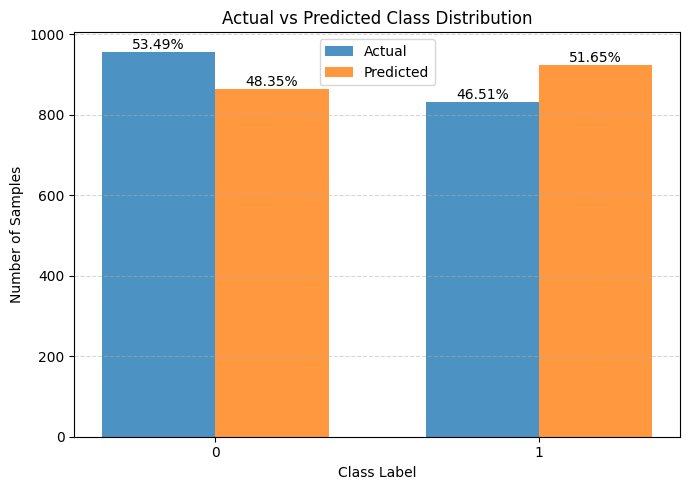

Final Test Accuracy: 82.22%


In [ ]:
# Compute actual and predicted distributions
actual_labels = y_test_tensor.cpu().numpy().flatten()
predicted_labels = y_pred.flatten()

actual_unique, actual_counts = np.unique(actual_labels, return_counts=True)
pred_unique, pred_counts = np.unique(predicted_labels, return_counts=True)
classes = sorted(set(np.unique(actual_labels)).union(np.unique(predicted_labels)))
actual_dist = [actual_counts[np.where(actual_unique == cls)[0][0]] if cls in actual_unique else 0 for cls in classes]
pred_dist = [pred_counts[np.where(pred_unique == cls)[0][0]] if cls in pred_unique else 0 for cls in classes]

# Plot bar graph
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(7, 5))
bars1 = plt.bar(x - width/2, actual_dist, width, label='Actual', alpha=0.8)
bars2 = plt.bar(x + width/2, pred_dist, width, label='Predicted', alpha=0.8)

# Add percentage annotations
for bar, total in zip(bars1, [sum(actual_dist)] * len(bars1)):
    height = bar.get_height()
    pct = height / total * 100
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{pct:.2f}%", ha='center', va='bottom', fontsize=10)

for bar, total in zip(bars2, [sum(pred_dist)] * len(bars2)):
    height = bar.get_height()
    pct = height / total * 100
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{pct:.2f}%", ha='center', va='bottom', fontsize=10)

# Final plot adjustments
plt.xticks(x, [str(int(c)) for c in classes])
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Actual vs Predicted Class Distribution")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Print final test accuracy
final_accuracy = (predicted_labels == actual_labels).sum() / len(actual_labels) * 100
print(f"Final Test Accuracy: {final_accuracy:.2f}%")


In [ ]:
def objective(trial):
    # Hyperparameters to tune
    hidden_1 = trial.suggest_int("hidden_1", 128, 1024, step=128)
    hidden_2 = trial.suggest_int("hidden_2", 64, 512, step=64)
    hidden_3 = trial.suggest_int("hidden_3", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5, step=0.05)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # Redefine model with suggested hyperparams
    class TunedMLP(nn.Module):
        def __init__(self, input_size):
            super(TunedMLP, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, hidden_1),
                nn.BatchNorm1d(hidden_1),
                nn.GELU(),
                nn.Dropout(dropout_rate),

                nn.Linear(hidden_1, hidden_2),
                nn.BatchNorm1d(hidden_2),
                nn.GELU(),
                nn.Dropout(dropout_rate),

                nn.Linear(hidden_2, hidden_3),
                nn.BatchNorm1d(hidden_3),
                nn.GELU(),
                nn.Dropout(dropout_rate),

                nn.Linear(hidden_3, 64),
                nn.GELU(),

                nn.Linear(64, 1),
                nn.Sigmoid()
            )

        def forward(self, x):
            return self.model(x)

    # Model, optimizer, loss
    model = TunedMLP(X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Train
    for epoch in range(20):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_class = (y_pred > 0.5).float()
            correct += (y_pred_class == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    return accuracy


# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Print results
print("Best trial:")
trial = study.best_trial

print(f"  Accuracy: {trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-06 04:46:07,260] A new study created in memory with name: no-name-1537d8f4-1328-4d10-8733-deb8831e2377
[I 2025-04-06 04:46:40,235] Trial 0 finished with value: 0.7350475125768586 and parameters: {'hidden_1': 384, 'hidden_2': 448, 'hidden_3': 256, 'dropout': 0.35, 'lr': 0.003988059565948506}. Best is trial 0 with value: 0.7350475125768586.
[I 2025-04-06 04:47:25,910] Trial 1 finished with value: 0.7221911682504192 and parameters: {'hidden_1': 1024, 'hidden_2': 448, 'hidden_3': 96, 'dropout': 0.5, 'lr': 0.0014716977693817737}. Best is trial 0 with value: 0.7350475125768586.
[I 2025-04-06 04:48:13,293] Trial 2 finished with value: 0.7367244270542203 and parameters: {'hidden_1': 1024, 'hidden_2': 512, 'hidden_3': 64, 'dropout': 0.45000000000000007, 'lr': 0.0003132067034879066}. Best is trial 2 with value: 0.7367244270542203.
[I 2025-04-06 04:48:33,277] Trial 3 finished with value: 0.8071548351034097 and parameters: {'hidden_1': 128, 'hidden_2': 128, 'hidden_3': 224, 'dropout': 0

Best trial:
  Accuracy: 0.8295
  Best hyperparameters:
    hidden_1: 896
    hidden_2: 192
    hidden_3: 32
    dropout: 0.30000000000000004
    lr: 0.0022488957358965385


In [ ]:
# Load best hyperparameters from Optuna
best_params = study.best_trial.params

# Define best-tuned model using best_params
class TunedMLP(nn.Module):
    def __init__(self, input_size):
        super(TunedMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, best_params['hidden_1']),
            nn.BatchNorm1d(best_params['hidden_1']),
            nn.GELU(),
            nn.Dropout(best_params['dropout']),

            nn.Linear(best_params['hidden_1'], best_params['hidden_2']),
            nn.BatchNorm1d(best_params['hidden_2']),
            nn.GELU(),
            nn.Dropout(best_params['dropout']),

            nn.Linear(best_params['hidden_2'], best_params['hidden_3']),
            nn.BatchNorm1d(best_params['hidden_3']),
            nn.GELU(),
            nn.Dropout(best_params['dropout']),

            nn.Linear(best_params['hidden_3'], 64),
            nn.GELU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, optimizer, loss, scheduler
model = TunedMLP(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

# Training loop
epochs = 50
train_losses = []
test_losses = []
epochs_list = []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        y_pred_class = (y_pred > 0.5).float()
        correct += (y_pred_class == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(train_loss)
    epochs_list.append(epoch + 1)
    scheduler.step()

    # Evaluation
    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            y_pred_class = (y_pred > 0.5).float()
            correct += (y_pred_class == y_batch).sum().item()
            total += y_batch.size(0)

    test_loss /= len(test_loader)
    test_accuracy = correct / total * 100
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")


Epoch 1/50 | Train Loss: 0.5823 | Train Acc: 69.06% | Test Loss: 0.5713 | Test Acc: 69.76%
Epoch 2/50 | Train Loss: 0.5446 | Train Acc: 71.79% | Test Loss: 0.5491 | Test Acc: 71.44%
Epoch 3/50 | Train Loss: 0.5263 | Train Acc: 73.64% | Test Loss: 0.5869 | Test Acc: 70.04%
Epoch 4/50 | Train Loss: 0.5149 | Train Acc: 74.94% | Test Loss: 0.5803 | Test Acc: 68.36%
Epoch 5/50 | Train Loss: 0.4979 | Train Acc: 75.66% | Test Loss: 0.5271 | Test Acc: 73.06%
Epoch 6/50 | Train Loss: 0.4689 | Train Acc: 77.79% | Test Loss: 0.4489 | Test Acc: 78.48%
Epoch 7/50 | Train Loss: 0.4474 | Train Acc: 78.73% | Test Loss: 0.4535 | Test Acc: 78.14%
Epoch 8/50 | Train Loss: 0.4318 | Train Acc: 79.96% | Test Loss: 0.4329 | Test Acc: 78.70%
Epoch 9/50 | Train Loss: 0.4208 | Train Acc: 80.24% | Test Loss: 0.6056 | Test Acc: 68.81%
Epoch 10/50 | Train Loss: 0.4219 | Train Acc: 80.45% | Test Loss: 0.5977 | Test Acc: 72.55%
Epoch 11/50 | Train Loss: 0.4060 | Train Acc: 81.13% | Test Loss: 0.4024 | Test Acc: 80.7

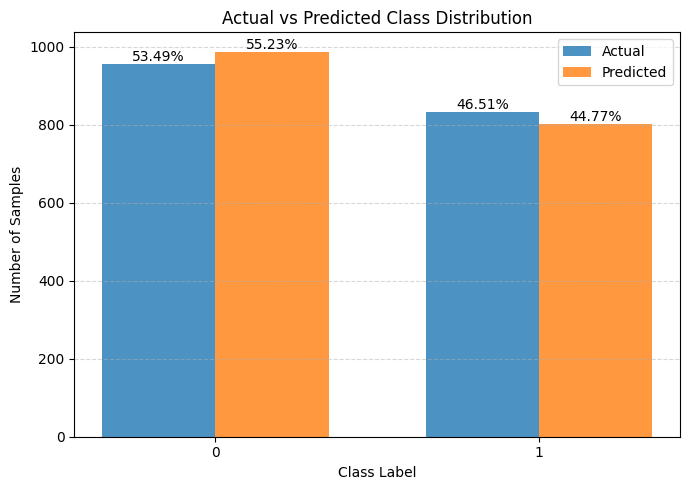

Final Test Accuracy: 83.29%


In [ ]:
model.eval()
with torch.no_grad():
    final_preds = (model(X_test_tensor.to(device)) > 0.5).float().cpu().numpy().flatten()
    actual_labels = y_test_tensor.cpu().numpy().flatten()

# Compute distributions
predicted_labels = final_preds
actual_unique, actual_counts = np.unique(actual_labels, return_counts=True)
pred_unique, pred_counts = np.unique(predicted_labels, return_counts=True)

# Align classes
classes = sorted(set(np.unique(actual_labels)).union(np.unique(predicted_labels)))
actual_dist = [actual_counts[np.where(actual_unique == cls)[0][0]] if cls in actual_unique else 0 for cls in classes]
pred_dist = [pred_counts[np.where(pred_unique == cls)[0][0]] if cls in pred_unique else 0 for cls in classes]

# Bar chart
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(7, 5))
bars1 = plt.bar(x - width/2, actual_dist, width, label='Actual', alpha=0.8)
bars2 = plt.bar(x + width/2, pred_dist, width, label='Predicted', alpha=0.8)

# Add percentage annotations
for bar, total in zip(bars1, [sum(actual_dist)] * len(bars1)):
    height = bar.get_height()
    pct = height / total * 100
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{pct:.2f}%", ha='center', va='bottom', fontsize=10)

for bar, total in zip(bars2, [sum(pred_dist)] * len(bars2)):
    height = bar.get_height()
    pct = height / total * 100
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{pct:.2f}%", ha='center', va='bottom', fontsize=10)

# Final styling
plt.xticks(x, [str(int(c)) for c in classes])
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Actual vs Predicted Class Distribution")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Accuracy
final_accuracy = (predicted_labels == actual_labels).sum() / len(actual_labels) * 100
print(f"Final Test Accuracy: {final_accuracy:.2f}%")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 896]          15,232
       BatchNorm1d-2                  [-1, 896]           1,792
              GELU-3                  [-1, 896]               0
           Dropout-4                  [-1, 896]               0
            Linear-5                  [-1, 192]         172,224
       BatchNorm1d-6                  [-1, 192]             384
              GELU-7                  [-1, 192]               0
           Dropout-8                  [-1, 192]               0
            Linear-9                   [-1, 32]           6,176
      BatchNorm1d-10                   [-1, 32]              64
             GELU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                   [-1, 64]           2,112
             GELU-14                   

PermutationExplainer explainer: 101it [01:02,  1.37it/s]
<ipython-input-56-25a3d770691f>:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_shap[:100], feature_names=feature_cols)


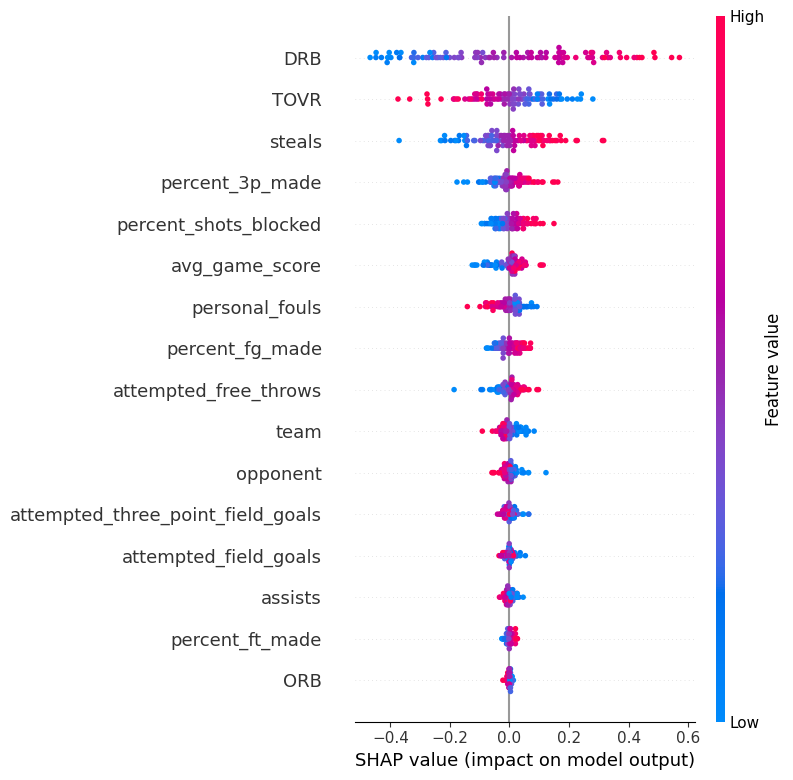

In [ ]:
num_input_features = X_train.shape[1]
summary(model, input_size=(num_input_features,))

# SHAP importances
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model
    def forward(self, x):
        # Convert input from numpy to torch if needed
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.to(next(self.model.parameters()).device)
        return self.model(x).cpu().detach().numpy()
wrapped_model = WrappedModel(model.to("cpu"))
X_shap = X_test_tensor.cpu().numpy()
explainer = shap.Explainer(wrapped_model, X_shap[:100])
shap_values = explainer(X_shap[:100])
shap.summary_plot(shap_values, features=X_shap[:100], feature_names=feature_cols)